# Changes
- max_features = 632

In [1]:
!ls -l ../input/

total 8
drwxr-xr-x 3 root root 4096 Oct 22 20:28 alice-logistic-regression-research
drwxr-xr-x 2 root root 4096 Dec  6  2018 catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2


In [2]:
!head ../input/train_sessions.csv

head: cannot open '../input/train_sessions.csv' for reading: No such file or directory


In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import sparse
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve

We will be solving the intruder detection problem analyzing his behavior on the Internet. It is a complicated and interesting problem combining the data analysis and behavioral psychology.

For example: Yandex solves the mailbox intruder detection problem based on the user's behavior patterns. In a nutshell, intruder's behaviour pattern might differ from the owner's one: 
- the breaker might not delete emails right after they are read, as the mailbox owner might do
- the intruder might mark emails and even move the cursor differently
- etc.

So the intruder could be detected and thrown out from the mailbox proposing the owner to be authentificated via SMS-code.
This pilot project is described in the Habrahabr article.

Similar things are being developed in Google Analytics and described in scientific researches. You can find more on this topic by searching "Traversal Pattern Mining" and "Sequential Pattern Mining".

In this competition we are going to solve a similar problem: our algorithm is supposed to analyze the sequence of websites consequently visited by a particular person and to predict whether this person is Alice or an intruder (someone else). As a metric we will use [ROC AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). We will reveal who Alice is at the end of the course.

###  Data Downloading and Transformation
First, read the training and test sets. 

In [ ]:
# Read the training and test data sets
train_df = pd.read_csv('../input/train_sessions.csv',
                       index_col='session_id', parse_dates=['time1'])
test_df = pd.read_csv('../input/test_sessions.csv',
                      index_col='session_id', parse_dates=['time1'])

In [ ]:
print(train_df.info())
train_df.head()

In [ ]:
print(test_df.info())
test_df.head()

In [ ]:
train_df.shape, test_df.shape

The training data set contains the following features:

- **site1** – id of the first visited website in the session
- **time1** – visiting time for the first website in the session
- ...
- **site10** – id of the tenth visited website in the session
- **time10** – visiting time for the tenth website in the session
- **target** – target variable, possesses value of 1 for Alice's sessions, and 0 for the other users' sessions
    
User sessions are chosen in the way they are not longer than half an hour or/and contain more than ten websites. I.e. a session is considered as ended either if a user has visited ten websites or if a session has lasted over thirty minutes.

There are some empty values in the table, it means that some sessions contain less than ten websites. Replace empty values with 0 and change columns types to integer. Also load the websites dictionary and check how it looks like:

Coding of missing data.
- Using `-1` for undefined site features.
- Using `0` for undefined time features.
- Using `-1` for undefined date (day, dom, week, mon) features.

In [ ]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
site_feature_names = [x for x in train_df.columns if 'site' in x]
for df in (train_df, test_df):
    df[site_feature_names] = df[site_feature_names].fillna(-1).astype('int').astype('str')
train_df[site_feature_names].head()

In [ ]:
%%time
# Add siteMN... features
site_feature_names = [x for x in train_df.columns if 'site' in x]
for df in (train_df, test_df):
    for l in range(2,len(site_feature_names)):
        for i in range(len(site_feature_names)-l+1):
            print('Progress: %d/%d, %d/%d\r' % (l,len(site_feature_names)-1,i,len(site_feature_names)-l), end='')
            df['site' + str(i) + str(l)] = df[site_feature_names[i:i+l]].apply(
                lambda x: '_'.join(x.values) if '-1' not in x.values else '-1', axis=1)

feature_names = [x for x in train_df.columns if 'site' in x]
print(feature_names[:1000])
print(feature_names[-1000:])
train_df[feature_names].head()

In [ ]:
# Fix timeN columns
time_feature_names = [x for x in train_df.columns if 'time' in x]
for df in (train_df, test_df):
    df[time_feature_names] = df[time_feature_names].fillna(0).astype('datetime64')
train_df[time_feature_names].head()

In [ ]:
# Add dur, durN columns
for df in (train_df, test_df):
    df.drop([x for x in df.columns if 'dur' in x], axis=1, inplace=True)

for df in (train_df, test_df):
    df['timex'] = pd.to_datetime(0)
time_feature_names = [x for x in train_df.columns if 'time' in x]
for df in (train_df, test_df):
    for i,k in [(x,x+1) for x in range(len(time_feature_names)-1)]:
        df['dur' + str(i)] = (df[time_feature_names[k]] - df[time_feature_names[i]]).astype('timedelta64[s]').astype('int')
        df.loc[df[time_feature_names[k]].astype('int') == 0, 'dur' + str(i)] = 0
dur_feature_names = [x for x in df.columns if 'dur' in x]
for df in (train_df, test_df):
    impute_dur = int(df[dur_feature_names].median().median())
    df['dur'] = df[dur_feature_names].sum(axis=1)
    for i,k in [(x,x+1) for x in range(len(time_feature_names)-1)]:
        df.loc[df[time_feature_names[k]].astype('int') == 0, 'dur' + str(i)] = impute_dur
for df in (train_df, test_df):
    df.drop('timex', axis=1, inplace=True)

feature_names = [x for x in train_df.columns if 'dur' in x]
print(train_df[feature_names].info())
train_df[feature_names].head()

In [ ]:
# Add dayN, hourN, minN, monN, domN, weekN columns
time_feature_names = [x for x in train_df.columns if 'time' in x]
for df in (train_df, test_df):
    for i in range(len(time_feature_names)):
        df['cat_day' + str(i)] = df[time_feature_names[i]].dt.dayofweek
        df['cat_hour' + str(i)] = df[time_feature_names[i]].dt.hour
        df['cat_min' + str(i)] = df[time_feature_names[i]].dt.minute
        df['cat_mon' + str(i)] = df[time_feature_names[i]].dt.month
        df['cat_dom' + str(i)] = df[time_feature_names[i]].dt.day
        df['cat_week' + str(i)] = df[time_feature_names[i]].dt.week
        df['cat_day_hour' + str(i)] = df[time_feature_names[i]].dt.dayofweek.astype('str') + '_' + df[time_feature_names[i]].dt.hour.astype('str')
        cat_feature_names = [x for x in df.columns if 'cat' in x and str(i) in x]
        df.loc[df[time_feature_names[i]].astype('int') == 0, cat_feature_names] = -1
        df[cat_feature_names] = df[cat_feature_names].astype('str') # for OHE

cat_feature_names = [x for x in train_df.columns if 'cat' in x]
print(train_df[cat_feature_names].info())
train_df[cat_feature_names].head()

In [4]:
train_df = pd.read_hdf('../input/alice-logistic-regression-research/train.h5')
test_df = pd.read_hdf('../input/alice-logistic-regression-research/test.h5')

---

In [8]:
train_df[[f for f in train_df.columns if 'dur' in f]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 11 columns):
dur0    253561 non-null int64
dur1    253561 non-null int64
dur2    253561 non-null int64
dur3    253561 non-null int64
dur4    253561 non-null int64
dur5    253561 non-null int64
dur6    253561 non-null int64
dur7    253561 non-null int64
dur8    253561 non-null int64
dur9    253561 non-null int64
dur     253561 non-null int64
dtypes: int64(11)
memory usage: 23.2 MB


In [ ]:
df = train_df.sort_values('time1')

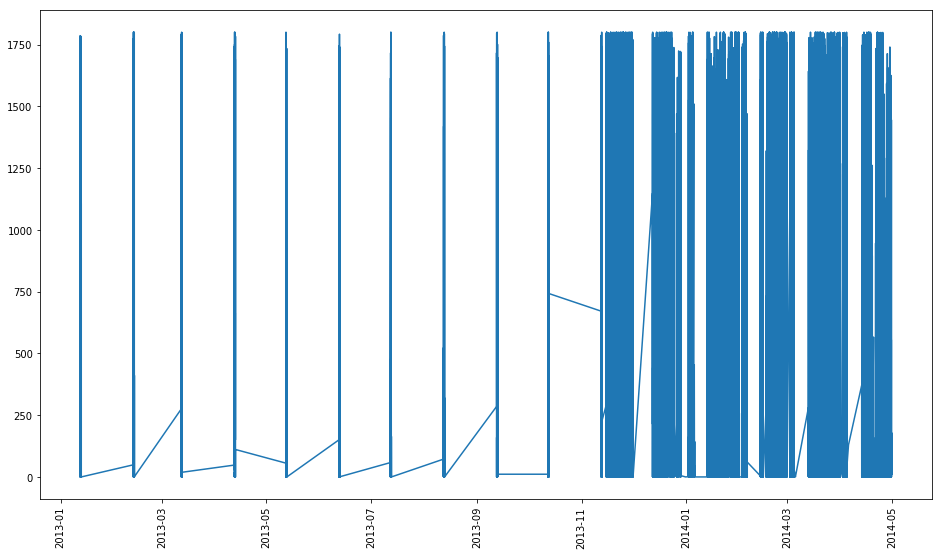

In [21]:
plt.figure(figsize=(16,9))
plt.plot(df['time1'], df['dur'])
plt.xticks(rotation='vertical')
plt.show()

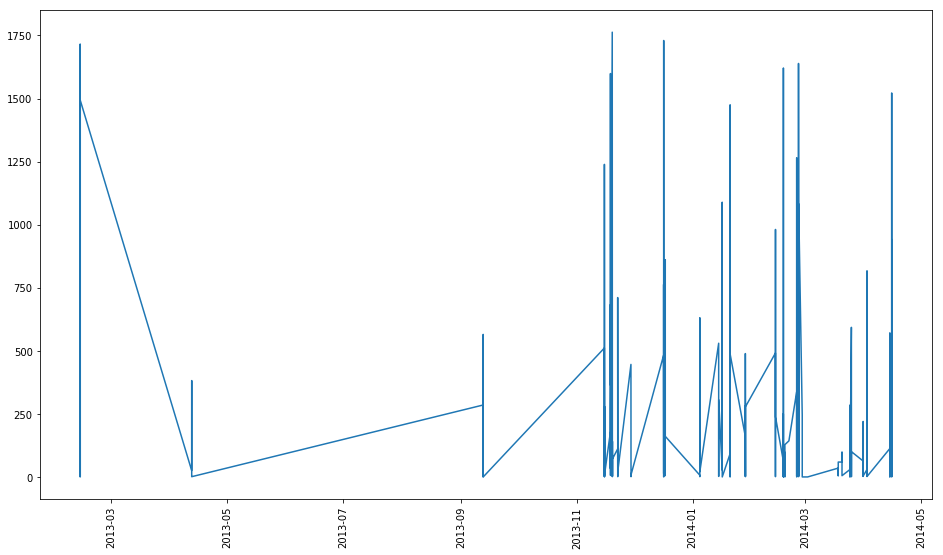

In [22]:
plt.figure(figsize=(16,9))
plt.plot(df[df['target'] == 1]['time1'], df[df['target'] == 1]['dur'])
plt.xticks(rotation='vertical')
plt.show()

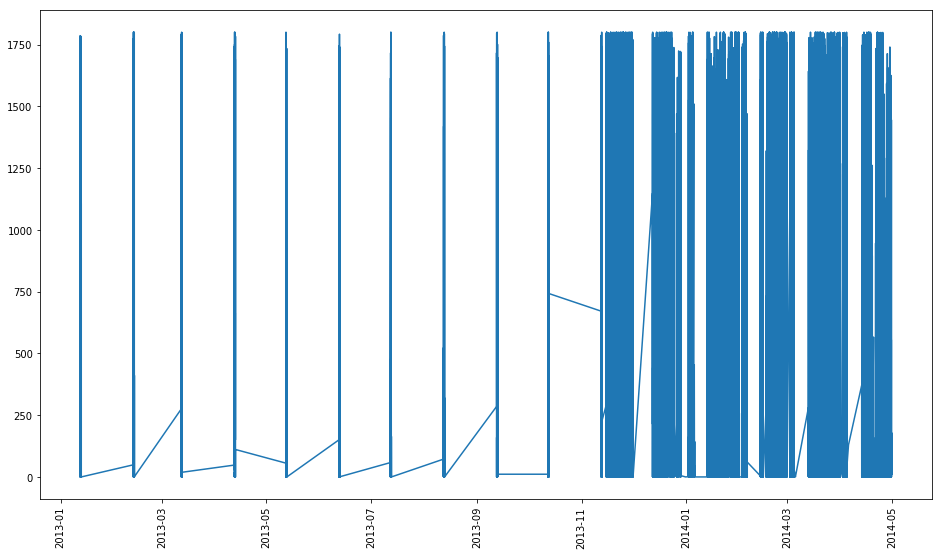

In [20]:
plt.figure(figsize=(16,9))
plt.plot(df[df['target'] == 0]['time1'], df[df['target'] == 0]['dur'])
plt.xticks(rotation='vertical')
plt.show()

In [23]:
df = test_df.sort_values('time1')

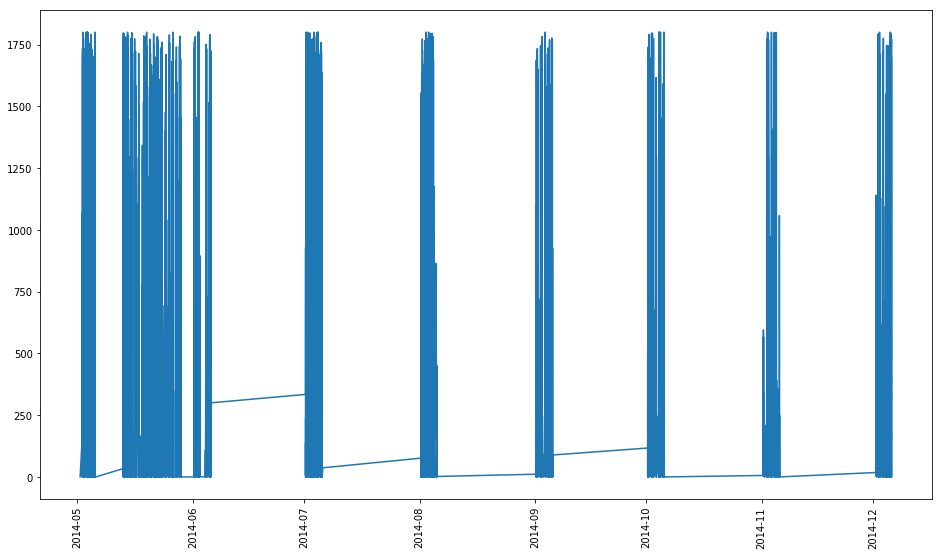

In [24]:
plt.figure(figsize=(16,9))
plt.plot(df['time1'], df['dur'])
plt.xticks(rotation='vertical')
plt.show()

In [28]:
train_df[train_df['target'] == 1].shape

(2297, 146)

In [29]:
test_df.shape

(82797, 145)

In [30]:
train_df.shape

(253561, 146)

---

In [ ]:
print(train_df.info())
train_df.head()

In [ ]:
print(test_df.info())
test_df.head()

In [ ]:
train_df.to_hdf('train.h5', 'train', mode='w')
test_df.to_hdf('test.h5', 'test', mode='w')

Using only common categories in train and test data set.

In [ ]:
site_feature_names = [x for x in train_df.columns if 'site' in x]
train_site_ids = set(train_df[site_feature_names].values.ravel())
test_site_ids = set(test_df[site_feature_names].values.ravel())
len(train_site_ids), len(test_site_ids), len(test_site_ids - train_site_ids), \
    len(test_site_ids & train_site_ids), len(train_site_ids | test_site_ids)

In [ ]:
#min(train_site_ids), min(test_site_ids), max(train_site_ids), max(test_site_ids)

In [ ]:
common_site_ids = [x for x in train_site_ids & test_site_ids if x != -1]
len(common_site_ids)

In [ ]:
def get_categories(df, cat_feature_names):
    categories = [set() for i in range(len(cat_feature_names))]
    for i,f in enumerate(cat_feature_names):
        categories[i] = set([x for x in df[f].values.ravel() if '-1' not in str(x)])
    return np.array(categories)

cat_feature_names = [x for x in train_df.columns if 'cat' in x]
train_categories = get_categories(train_df, cat_feature_names)
test_categories = get_categories(test_df, cat_feature_names)

np.sum([len(c) for c in train_categories]), np.sum([len(c) for c in test_categories]), \
    np.sum([len(c) for c in (train_categories - test_categories)]), \
    np.sum([len(c) for c in (train_categories & test_categories)])

In [ ]:
common_categories = [list(c) for c in train_categories & test_categories if '-1' not in str(c)]
np.sum([len(c) for c in common_categories])

For the very basic model, we will use only the visited websites in the session (but we will not take into account timestamp features). The point behind this data selection is: *Alice has her favorite sites, and the more often you see these sites in the session, the higher probability that this is an Alice's session, and vice versa.*

Let us prepare the data, we will take only features `site1, site2, ... , site10` from the whole dataframe. Keep in mind that the missing values are replaced with zero. Here is how the first rows of the dataframe look like:

In [ ]:
y_train = train_df['target'].values
X_train_feature_names = []

In [ ]:
%%time
cv_voc = dict([(common_site_ids[i],i) for i in range(len(common_site_ids))])
def cv_get_feature_names(cv):
    rev_voc = dict([(cv.vocabulary_[i],i) for i in cv.vocabulary_])
    keys = list(rev_voc.keys())
    keys.sort()
    vals = []
    for i in keys:
        vals += [rev_voc[i]]
    return vals
cv = CountVectorizer(analyzer=lambda x: x,vocabulary=cv_voc)
site_feature_names = [x for x in train_df.columns if 'site' in x]
X_train = cv.fit_transform(train_df[site_feature_names].values)
X_train_feature_names += cv_get_feature_names(cv)
X_train.shape, len(X_train_feature_names)

In [ ]:
feature_names = [x for x in train_df.columns if 'dur' in x]
X_train = sparse.hstack([X_train, train_df[feature_names].values])
X_train_feature_names += feature_names
X_train.shape, len(X_train_feature_names)

In [ ]:
ohe = OneHotEncoder(dtype='int8', categories=common_categories, handle_unknown='ignore')
def ohe_get_feature_names(ohe, names):
    f_names = []
    assert(len(names) == len(ohe.categories_))
    for c_i in range(0,len(ohe.categories_)):
        f_names += [names[c_i] + '_' + str(f) for f in ohe.categories_[c_i]]
    return f_names

In [ ]:
feature_names = [x for x in train_df.columns if 'cat' in x]
X_train = sparse.hstack([X_train, ohe.fit_transform(train_df[feature_names])])
X_train_feature_names += ohe_get_feature_names(ohe, feature_names)
X_train.shape, len(X_train_feature_names)

In [ ]:
feature_names = [x for x in X_train_feature_names if '-1' in str(x)]
print(feature_names[:1000])
print(feature_names[-1000:])

In [ ]:
# Remove undefined cat features (filled with '-1')
retain_indices = [i for i in range(len(X_train_feature_names)) if '-1' not in str(X_train_feature_names[i])]
X_train = X_train.tocsc()[:,retain_indices]
X_train_feature_names = np.array(X_train_feature_names)[retain_indices]
X_train.shape, len(X_train_feature_names)

In [ ]:
sparse.save_npz('train.npz', X_train)
pickle.dump({'y': y_train, 'feature_names': X_train_feature_names}, open('train.p', 'wb'))

In [ ]:
#X_train = sparse.load_npz('train.npz')
#train_p = pickle.load(open('train.p', 'rb'))
#y_train = train_p['y']
#X_train_feature_names = train_p['feature_names']

In [ ]:
logit = LogisticRegression(random_state=17, solver='lbfgs', max_iter=500, verbose=3)
m = Pipeline([('logit', logit)])
m.get_params()

In [ ]:
plot_cnt=50

### Exploratory data analysis

In [ ]:
%%time
saved_max_iter = m.get_params()['logit__max_iter']
m.set_params(logit__max_iter=20000)
saved_n_jobs = m.get_params()['logit__n_jobs']
m.set_params(logit__n_jobs=1) # for ConvergenceWarning

print(m.get_params())
m.fit(X_train, y_train)
X_train_feature_imp_coefs = m.named_steps['logit'].coef_.ravel()
X_train_feature_imp_idxs = np.argsort(X_train_feature_imp_coefs)
print(X_train_feature_names[X_train_feature_imp_idxs][:1000])
print(X_train_feature_names[X_train_feature_imp_idxs][-1000:])

m.set_params(logit__max_iter=saved_max_iter)
m.set_params(logit__n_jobs=saved_n_jobs)
m.get_params()

In [ ]:
pickle.dump({'coefs': X_train_feature_imp_coefs, 'idxs': X_train_feature_imp_idxs}, open('f_imp.p', 'wb'))

In [ ]:
X_train = X_train.tocsc() # for column indexing

In [ ]:
def plot_imp(coefs, feature_names, n_top_features=25):
    positive_coefficients = np.argsort(coefs)[-n_top_features:]
    negative_coefficients = np.argsort(coefs)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    colors = ["red" if c < 0 else "blue" for c in coefs[interesting_coefficients]]
    plt.figure(figsize=(160, 9))
    plt.bar(np.array(feature_names)[interesting_coefficients], coefs[interesting_coefficients], color=colors)
    plt.xticks(rotation=60, ha="right")
    plt.show()
plot_imp(X_train_feature_imp_coefs, X_train_feature_names, 250)

### Validation curves

In [ ]:
%%time
def plot_vc_features(f_cnt_min, f_cnt_max):
    xx = range(f_cnt_min, f_cnt_max, int(np.ceil((f_cnt_max-f_cnt_min)/plot_cnt)))
    vc_test = []
    for f_cnt in xx:
        print('Progress: %d%% (%d/%d)\r' % ((f_cnt-f_cnt_min)*100//(f_cnt_max-f_cnt_min), f_cnt, f_cnt_max), end='')
        scores = cross_val_score(m, X_train[:,X_train_feature_imp_idxs[-f_cnt:]], y_train,
                                 cv=5, scoring='roc_auc', n_jobs=-1, verbose=0)
        vc_test += [scores]
    plt.plot(xx, np.mean(vc_test, axis=1), c='red', label='test')
    plt.plot(xx, np.min(vc_test, axis=1), c='blue', label='min')
    plt.xlabel('Count')
    plt.ylabel('Score')
    plt.title('Feature count')
    plt.legend()
    plt.show()
    scores = np.min(vc_test, axis=1)
    best_idx = np.argmax(scores)
    return scores[best_idx], xx[best_idx]
plot_vc_features(10, 60000)

In [ ]:
%%time
plot_vc_features(1, 5000)

In [ ]:
%%time
plot_vc_features(1, 1000)

In [ ]:
max_features = 632

In [ ]:
%%time
def plot_vc_C(C_min, C_max):
    C = np.linspace(C_min, C_max, plot_cnt)
    grid = GridSearchCV(m, param_grid={'logit__C': C}, return_train_score=True,
                        cv=5, scoring='roc_auc', n_jobs=-1, verbose=3)
    grid.fit(X_train[:,X_train_feature_imp_idxs[-max_features:]], y_train)
    vc_train = np.vstack([grid.cv_results_[x] for x in grid.cv_results_ if 'train_score' in x and 'split' in x]).T
    vc_test = np.vstack([grid.cv_results_[x] for x in grid.cv_results_ if 'test_score' in x and 'split' in x]).T
    plt.plot(C, np.mean(vc_train, axis=1), c='green', label='train')
    plt.plot(C, np.mean(vc_test, axis=1), c='red', label='test')
    plt.plot(C, np.min(vc_test, axis=1), c='blue', label='min')
    plt.legend()
    plt.show()
    return grid.best_score_, grid.best_params_
plot_vc_C(1e-5, 1)

The baseline is **0.91252**

Strong baseline is **0.95965**

In [ ]:
%%time
plot_vc_C(1e-5, 0.5)

In [ ]:
%%time
plot_vc_C(1e-5, 0.3)

In [ ]:
plot_vc_C(1e-5, 0.1)

In [ ]:
%%time
plot_vc_C(1e-5, 0.05)

### Learning curves

In [ ]:
%%time
def plot_lc(C):
    m.set_params(logit__C=C)
    train_sizes, train_scores, test_scores = learning_curve(
        m, X_train[:,X_train_feature_imp_idxs[-max_features:]], y_train,
        train_sizes=np.linspace(0.01,1,plot_cnt),
        cv=5, scoring='roc_auc', n_jobs=-1, verbose=3,
        shuffle=True, random_state=17)
    plt.plot(train_sizes, np.mean(train_scores, axis=1), c='green', label='train')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), c='red', label='test')
    plt.plot(train_sizes, np.min(test_scores, axis=1), c='blue', label='min')
    plt.legend()
    plt.title('C=' + str(C))
    plt.show()
plot_lc(1)

In [ ]:
%%time
plot_lc(0.2)

In [ ]:
%%time
plot_lc(0.1)

In [ ]:
%%time
plot_lc(0.05)

In [ ]:
%%time
plot_lc(1e-5)

In [ ]:
!ls -l